# Packet Analysis Using Data Science

***

## Getting Started

***

The first thing we are going to do in order to make all this possible, is downloading and importing a few libraries. These include:
+ [**Scapy**](https://scapy.net)- For packet manupilation.
+ [**Pandas**](https://pandas.pydata.org/) - To help us create and manupilate dataframes.
+ [**Numpy**](http://www.numpy.org/) - To help us perform complex mathematical functions.
+ [**Binascii**](https://docs.python.org/2/library/binascii.html) - To help us convert from Binary to Ascii.
+ [**Seaborn**](https://seaborn.pydata.org/) - For some awesome visualization. 

We are also going to add the Matplotlib inline (`%matplotlib inline`) function, to allow any visualization to appear within the notebook itself. 

In [2]:
!pip install scapy

    100% |████████████████████████████████| 798kB 1.6MB/s eta 0:00:01
  Running setup.py bdist_wheel for scapy ... error
  Complete output from command /opt/conda/envs/DSX-Python35/bin/python -u -c "import setuptools, tokenize;__file__='/home/dsxuser/.tmp/pip-build-ie6kblit/scapy/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /home/dsxuser/.tmp/tmp1j4n2w5jpip-wheel- --python-tag cp35:
  /opt/conda/envs/DSX-Python35/lib/python3.5/distutils/dist.py:261: UserWarning: Unknown distribution option: 'project_urls'
    warnings.warn(msg)
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creating build/lib/scapy
  copying scapy/themes.py -> build/lib/scapy
  copying scapy/volatile.py -> build/lib/scapy
  copying scapy/scapypipes.py -> build/lib/scapy
  copying scapy/all.py -> build/lib/scapy
  copying scapy/route.py -> build/lib/scapy
  copyin

In [3]:
%matplotlib inline

from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import seaborn as sns

sns.set(color_codes=True)

## Sniffing packets in Scapy

***

Scapy is a tool that provides powerfull and interactive packet manupilation. it allows you to forge or decode packets of a wide number of protocols, send them on wire, capture them, match requests and replies, etc. Packet capture and analysis can primarily be accomplished using Wireshark, however, it is hard to keep track of multiple suspicious indicators while also keeping track of multiple connections in Wireshark. Manupliating packets in Scapy can get a little rigid, so we transform our packet capture into a Panda DataFrame. 



In [4]:
# num_of_packets_to_sniff = 100
# pcap = sniff(count=num_of_packets_to_sniff)

# print(type(pcap))
# print(len(pcap))
# print(pcap)
# pcap[0]

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
# Retrieving a single item from the packet list

ethernet_frame = pcap[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload

print("ethernet_frame : ", ethernet_frame.summary())
print("ip_packet : ", ip_packet.summary())
print("segment : ", segment.summary())
print("data : ", data.summary()) # If blank, empty object

ethernet_frame.show()

ethernet_frame :  Ether / ARP who has 24.166.173.159 says 24.166.172.1 / Padding
ip_packet :  ARP who has 24.166.173.159 says 24.166.172.1 / Padding
segment :  Padding
data :  
###[ Ethernet ]### 
  dst       = ff:ff:ff:ff:ff:ff
  src       = 00:07:0d:af:f4:54
  type      = 0x806
###[ ARP ]### 
     hwtype    = 0x1
     ptype     = 0x800
     hwlen     = 6
     plen      = 4
     op        = who-has
     hwsrc     = 00:07:0d:af:f4:54
     psrc      = 24.166.172.1
     hwdst     = 00:00:00:00:00:00
     pdst      = 24.166.173.159
###[ Padding ]### 
        load      = '\x06\x01\x04\x00\x00\x00\x00\x02\x01\x00\x03\x02\x00\x00\x05\x01\x03\x01'



## Converting the PCAP frames to DataFrames

***



In [7]:
#Collect the field names from IP/TCP/UDP (These will be the columns in the DataFrame)

ip_fields =[field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

# print("ip_fields : ", ip_fields)
# print("tcp_fields : ", tcp_fields)
# print("udp_fields : ", udp_fields)

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload', 'payload_raw', 'payload_hex']

print("Dataframe_fields : ", dataframe_fields)

# Create a blank DataFrame.
df = pd.DataFrame(columns = dataframe_fields)

for packet in pcap[IP]:
    #Field array for each row of DataFrame
    field_values = []
    # Add all field values
    for field in ip_fields:
        if field == 'options':
            # Retrieving the number of options defined in IP headers
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
            
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
            
    # Append payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Add row to DF
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")
        
        

Dataframe_fields :  ['version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto', 'chksum', 'src', 'dst', 'options', 'time', 'sport', 'dport', 'seq', 'ack', 'dataofs', 'reserved', 'flags', 'window', 'chksum', 'urgptr', 'options', 'payload', 'payload_raw', 'payload_hex']


## DataFrame Basics 

***

In [8]:
# Retrieve first row from DataFrame
print(df.iloc[0])

print(df.shape)

# Return first 5 rows
df.head()

# Return last 5 rows
df.tail()

version                                                        4
ihl                                                            5
tos                                                            0
len                                                           76
id                                                             1
flags                                                           
frag                                                           0
ttl                                                           64
proto                                                         17
chksum                                                     63794
src                                                 192.168.0.12
dst                                                 192.168.0.17
options                                                        0
time                                                 1.49239e+09
sport                                                         53
dport                    

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
3130,4,5,0,52,35619,DF,0,64,6,26588,...,8,0,A,31856,59592,0,3,0,b'',b''
3131,4,5,0,84,35620,DF,0,64,6,26555,...,8,0,PA,31856,18960,0,3,32,b'\x05\x01\xca\x02T\xf24I%\x00\x00\x00\x16\x00...,b'0501ca0254f234492500000016004003000000008202...
3132,4,5,0,932,15302,DF,0,64,6,46025,...,8,0,PA,31856,5851,0,3,880,b'\x02\x00\x04\x00\x16\x00@\x03\x01\x00\x00\x0...,b'020004001600400301000000010000003d0004001600...
3133,4,5,0,76,1,,0,64,17,63794,...,None,None,None,None,13485,None,None,48,b'llllllllllllllllllllllllllllllllllllllllllll...,b'6c6c6c6c6c6c6c6c6c6c6c6c6c6c6c6c6c6c6c6c6c6c...
3134,4,5,0,130,35935,,0,128,17,62092,...,None,None,None,None,51235,None,None,102,"b""\xff\xff\xff\xff\xff\xff\x00\x90'\x85\xcf\x0...",b'ffffffffffff00902785cf0100902785cf0100902785...


## PCAP Statistics

***

One of the advantages of converting our PCAP packet frames to a Pandas DataFrame is that, now we can perform statistics on it. One of the most cumbersome aspects of Wireshark is that there is tons and tons of data, which makes it very hard to make any real insights from it, efficiently. With the help of Pandas we can perform some simple statistics, like seeing the most frequently used source address, or the most frequent destination address or port.



In [12]:
# Top Source Adddress
print("[*] Top Source Address: \n", df['src'].describe(), "\n\n")

# Top Destination Address
print("[*] Top Destination Address: \n ", df['dst'].describe(), "\n\n")

frequent_address = df['src'].describe()['top']

# Who is the top address speaking to
print("[*] Who is Top Address Speaking to?: \n ", df[df['src'] == frequent_address]['dst'].unique(), "\n\n")

# Who is the top address speaking to (dst ports)
print("[*] Who is the top address speaking to (Destination Ports): \n ", df[df['src'] == frequent_address]['dport'].unique(), "\n\n")

# Who is the top address speaking to (src ports)
print("[*] Who is the top address speaking to (Source Ports): \n", df[df['src'] == frequent_address]['sport'].unique(), "\n\n")

[*] Top Source Address: 
 count            3135
unique            177
top       192.168.1.2
freq             1177
Name: src, dtype: object 


[*] Top Destination Address: 
  count            3135
unique            197
top       192.168.1.2
freq             1068
Name: dst, dtype: object 


[*] Who is Top Address Speaking to?: 
  ['212.204.214.114' '192.168.1.1' '71.10.179.129' '172.200.160.242'
 '86.128.100.24' '68.95.198.126' '86.128.187.110' '24.177.122.79'
 '68.32.70.119' '86.197.95.238' '86.31.70.81' '86.220.100.25'
 '86.130.63.111' '80.216.195.140' '65.190.6.124' '165.124.253.241'
 '81.236.228.111' '86.142.117.124' '86.142.178.222' '86.128.163.125'
 '86.134.79.66' '86.136.192.70' '80.186.57.176' '68.206.150.243'
 '82.128.194.105' '204.152.205.205' '195.215.8.141' '83.147.171.206'
 '172.207.190.217' '190.44.165.86' '83.130.238.168' '83.5.146.219'
 '82.253.163.244' '202.139.177.147' '202.232.205.123' '130.244.145.31'
 '217.41.176.118' '212.72.49.142' '212.149.248.49' '67.190.60.125'


## Visualizations

***

Now that we have the statistics, the next step is to visualize the data. Visualization helps you identify most frequent addresses and ports much quicker and efficiently, and also identify anomolous activity in a glance. 


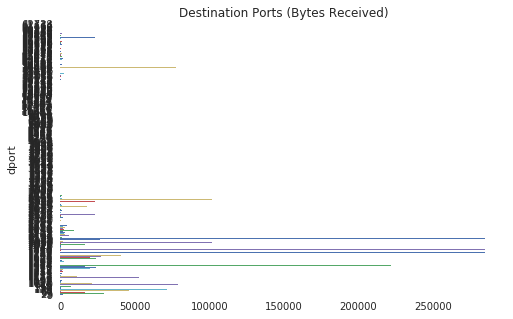

In [10]:
# Group by Source Address and Payload Sum
source_addresses = df.groupby("src")['payload'].sum()
source_addresses.plot(kind='barh',title="Addresses Sending Payloads",figsize=(8,5))

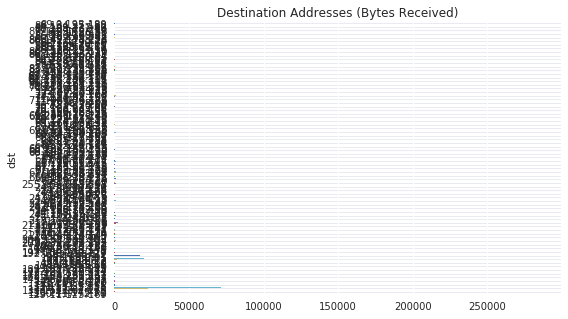

In [13]:
# Group by Destination Address and Payload Sum
destination_addresses = df.groupby("dst")['payload'].sum()
destination_addresses.plot(kind='barh', title="Destination Addresses (Bytes Received)",figsize=(8,5))

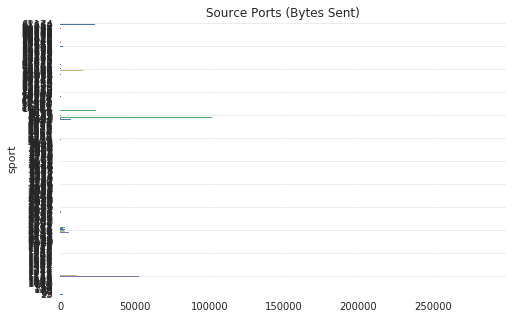

In [14]:
# Group by Source Port and Payload Sum
source_payloads = df.groupby("sport")['payload'].sum()
source_payloads.plot(kind='barh',title="Source Ports (Bytes Sent)",figsize=(8,5))

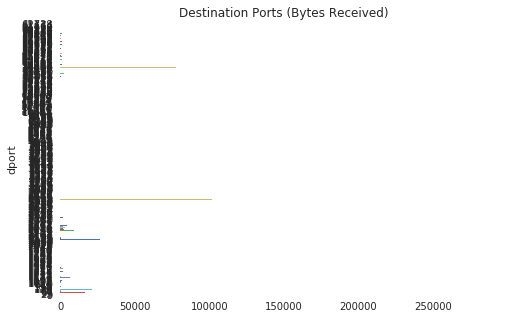

In [15]:
# Group by Destination Port and Payload Sum
destination_payloads = df.groupby("dport")['payload'].sum()
destination_payloads.plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))

## Payload Investigation

***

The graphs that we created highlighted the fact that a large amount of data was sent over port 53. Exfiltrating data using this port is a common technique for attackers due to the fact that restricting DNS communication can be troublesome. At this point, we can open wireshark or write a few lines of code to make this action repeatable. We’ll perform another grouping operation, separate the conversation into its own dataframe, and view the suspicious conversation:



192.168.1.1 May be a suspicious address
[b'1\x1f\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x012\x011\x03168\x03192\x07in-addr\x04arpa\x00\x00\x0c\x00\x01', b'1 \x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x03114\x03214\x03204\x03212\x07in-addr\x04arpa\x00\x00\x0c\x00\x01', b'1!\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x08sterling\x08freenode\x03net\x00\x00\x01\x00\x01', b'1"\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x011\x011\x03168\x03192\x07in-addr\x04arpa\x00\x00\x0c\x00\x01', b'1#\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x07voyager\x04home\x00\x00\x01\x00\x01', b'1$\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x03129\x03179\x0210\x0271\x07in-addr\x04arpa\x00\x00\x0c\x00\x01', b'1%\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x03242\x03160\x03200\x03172\x07in-addr\x04arpa\x00\x00\x0c\x00\x01', b'1&\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\r71-10-179-129\x04dhcp\x04stls\x02mo\x07charter\x03com\x00\x00\x01\x00\x01', b"1'\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x08ACC8A0F2\x03ipt\x03aol\x03com\x00\x00\x01\

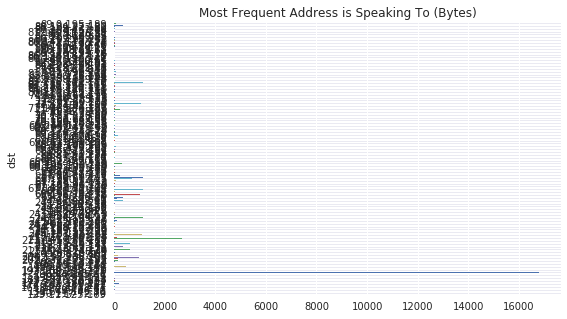

In [11]:
# Create dataframe with only converation from most frequent address
frequent_address_df = df[df['src']==frequent_address]

# Only display Src Address, Dst Address, and group by Payload 
frequent_address_groupby = frequent_address_df[['src','dst','payload']].groupby("dst")['payload'].sum()

# Plot the Frequent address is speaking to (By Payload)
frequent_address_groupby.plot(kind='barh',title="Most Frequent Address is Speaking To (Bytes)",figsize=(8,5))

# Which address has excahnged the most amount of bytes with most frequent address
suspicious_ip = frequent_address_groupby.sort_values(ascending=False).index[0]
print(suspicious_ip, "May be a suspicious address")

# Create dataframe with only conversation from most frequent address and suspicious address
suspicious_df = frequent_address_df[frequent_address_df['dst']==suspicious_ip]

# Store each payload in an array
raw_stream = []
for p in suspicious_df['payload_raw']:
    raw_stream.append(p)
    
print(raw_stream)

***